In [1]:
from torch.utils.data import DataLoader 
import torch
import matplotlib.pyplot as plt
from pyscf import gto, dft, scf 
from pyscf.lib import chkfile
from kspies import wy, zmp
from dpyscfl.scf import *
from dpyscfl.net import *
from dpyscfl.utils import *
from dpyscfl.losses import *
import os, shutil, copy
from ase import Atoms, Atom
from ase.units import Bohr, Hartree, kJ, mol
import pickle
import pandas as pd
from ase.io import read, write
from torchviz import make_dot
import pylibnxc

## Testing Pretrained Model (SCAN)
Set up the "reference" energies to be the SCAN calculated energies.

In [2]:
scanpt = '/home/awills/Documents/Research/dpyscfl/models/pretrained/scan'
scf = get_scf('MGGA', pretrain_loc=scanpt)
torch.save(scf, '/home/awills/Documents/Research/swxcd/eval/pt/scan/xc')

FREEC False
Loading pre-trained models from /home/awills/Documents/Research/dpyscfl/models/pretrained/scan


In [3]:
tt = read('/home/awills/Documents/Research/swxcd/aegis/rhscanrxn/calc_results.traj', ':')
th = read('/home/awills/Documents/Research/swxcd/aegis/rhscanrxn/haunschild_scan_reaction.traj', ':')
rh = read('/home/awills/Documents/Research/xcdiff/data/ref_haunschild_scan_reaction.traj', ':')
energies = np.loadtxt('/home/awills/Documents/Research/xcdiff/data/ref/6-311/energies')[:, 1]

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


In [4]:
for idx, at in enumerate(rh):
    en = energies[idx]
    print(idx, at, at.info, en)

0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False} -0.17434014967795244
1 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False} -0.36405261150717777
2 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False} -0.22243004393513086
3 Atoms(symbols='CNH', pbc=False, calculator=SinglePointCalculator(...)) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False} -0.4993221026004529
4 Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12} -0.6223386877991182
5 Atoms(symbols='Cl2', pbc=False, calculator=SinglePointCalculator(...)) {'Cl2': True, 'name': 'Dichlorine', 'n_rad': 3, 'n_ang': 20, 'spin': 0, 'pol

In [10]:
pop = [34, 33, 32, 10, 7, 5]
[rh[i] for i in pop]

[Atoms(symbols='HON2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='N2O', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='H', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='ClH', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='O2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='Cl2', pbc=False, calculator=SinglePointCalculator(...))]

In [11]:
tt[0].positions

array([[ 0.      ,  0.      ,  0.371395],
       [ 0.      ,  0.      , -0.371395]])

In [12]:
for idx, at in enumerate(tt):
    en = energies[idx]
    calc_en = at.calc.results['energy']
    print(en)
    print(calc_en)
    if len(at.positions) > 1:
        at.info['e_calc'] = calc_en
    try:
        at.calc.results['energy'] = en
    except:
        at.calc = th[0].calc
        at.calc.results['energy'] = en
write('/home/awills/Documents/Research/swxcd/aegis/rhscanrxn/results.traj', tt)

-0.17434014967795244
-1.172348868118458
-0.36405261150717777
-109.41916257848293
-0.22243004393513086
-107.3059420513648
-0.4993221026004529
-93.32175404374792
-0.6223386877991182
-188.40175875393848
-0.09454200500963746
-919.5958912233348
-0.06182061410488379
-199.33646597252772
-0.19267951613196113
-150.12619657260814
-0.6458922998762915
-77.2336470838157
-0.4142335363320095
-113.20173021830034
-0.17123597861668197
-460.4234539504378
-0.09227576969496765
-8.03807992441894
-0.027339558132268862
-324.03216777706615
-37.8405
-37.799082966678306
-460.148
-459.7548399975846
-99.7339
-99.64090370770167
-0.5
-0.49981791563042005
-7.47806
-7.447596712081991
-54.5892
-54.53396413910467
-162.2546
-162.00214355971488
-75.0673
-74.99416120454066
-0.008466
-129.53258703848292
-0.36339749810529004
-204.87297985889344
-0.132172937629701
-55.09241833998687
-0.2345382154735096
-225.20206707949464
-0.43180352541868494
-184.47901445491146
-0.4902723965371663
-39.78388688523679
-0.3036488705738187
-39.0

In [13]:
for idx, at in enumerate(tt):
    print(idx, at, at.info, at.calc.results)


0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'e_calc': -1.172348868118458} {'energy': -0.17434014967795244}
1 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False, 'e_calc': -109.41916257848293} {'energy': -0.36405261150717777}
2 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False, 'e_calc': -107.3059420513648} {'energy': -0.22243004393513086}
3 Atoms(symbols='CNH', pbc=False, calculator=SinglePointCalculator(...)) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False, 'e_calc': -93.32175404374792} {'energy': -0.4993221026004529}
4 Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12, 

In [14]:
#tmp = read('/home/awills/Documents/Research/swxcd/aegis/xcd_scan/calc_results.traj', ':')
tmp = read('/home/awills/Documents/Research/swxcd/aegis/rhscanrxn/results.traj', ':')

In [15]:
for idx, at in enumerate(tmp):
    print(idx, at, at.info, at.calc.results)
    at.info['energy'] = at.calc.results['energy']
write('/home/awills/Documents/Research/swxcd/aegis/xcd_scan/einfo.traj', tmp)

0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'e_calc': -1.172348868118458} {'energy': -0.17434014967795244}
1 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False, 'e_calc': -109.41916257848293} {'energy': -0.36405261150717777}
2 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False, 'e_calc': -107.3059420513648} {'energy': -0.22243004393513086}
3 Atoms(symbols='CNH', pbc=False, calculator=SinglePointCalculator(...)) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False, 'e_calc': -93.32175404374792} {'energy': -0.4993221026004529}
4 Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12, 

# The Published Network

The network published has been saved in `dpyscfl/models/xcdiff/MODEL_MGGA`

In [2]:
xcdp = '/home/awills/Documents/Research/dpyscfl/models/xcdiff/MODEL_MGGA/'
xcd = torch.jit.load(os.path.join(xcdp, 'xc'))
print(xcd)
for n,p in xcd.named_parameters():
    print (n, p)

RecursiveScriptModule(
  original_name=XC
  (heg_model): RecursiveScriptModule(original_name=LDA_X)
  (pw_model): RecursiveScriptModule(original_name=PW_C)
  (grid_models): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=XC_L
      (net): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Linear)
        (1): RecursiveScriptModule(original_name=GELU)
        (2): RecursiveScriptModule(original_name=Linear)
        (3): RecursiveScriptModule(original_name=GELU)
        (4): RecursiveScriptModule(original_name=Linear)
        (5): RecursiveScriptModule(original_name=GELU)
        (6): RecursiveScriptModule(original_name=Linear)
      )
      (tanh): RecursiveScriptModule(original_name=Tanh)
      (sig): RecursiveScriptModule(original_name=Sigmoid)
      (lobf): RecursiveScriptModule(
        original_name=LOB
        (sig): RecursiveScriptModule(original_name=Sigmoid)
      )
   

In [3]:
xcd.state_dict()

OrderedDict([('grid_models.0.net.0.weight',
              tensor([[ -1.7256,  -0.7583],
                      [ -0.7135,  -0.4243],
                      [ -0.0929,  -4.0847],
                      [  0.1295,  -0.6161],
                      [-11.2182,  -1.2587],
                      [-47.5842,   0.0798],
                      [ -7.2921,  -0.4032],
                      [ -0.4546,   0.1030],
                      [ -1.5343,  -1.2948],
                      [ -3.5488,  -2.6906],
                      [  0.8545,   0.3988],
                      [ -1.1457,   0.0605],
                      [ -3.8406,   0.0731],
                      [ -0.6009,   0.1400],
                      [  0.7541,  -0.1070],
                      [ -2.9376,  -0.1989]])),
             ('grid_models.0.net.0.bias',
              tensor([ 1.0763,  0.9693, -0.1023,  0.1779, -2.7520,  0.3602, -0.3192,  1.3729,
                      -0.1036, -1.5152, -0.5317,  0.4798,  0.6637,  0.4314, -0.0635,  0.3054])),
             ('g

This is loaded into training script with `dpyscfl.net.get_scf`, so we must verify it is loaded in correctly.

In [5]:
xcds = get_scf(xctype='MGGA', path=os.path.join(xcdp, 'xc'))
print(xcds.xc)
for n,p in xcds.xc.named_parameters():
    print (n, p)

FREEC False
XC(
  (heg_model): LDA_X()
  (pw_model): PW_C()
  (grid_models): ModuleList(
    (0): XC_L(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=16, bias=True)
        (1): GELU()
        (2): Linear(in_features=16, out_features=16, bias=True)
        (3): GELU()
        (4): Linear(in_features=16, out_features=16, bias=True)
        (5): GELU()
        (6): Linear(in_features=16, out_features=1, bias=True)
      )
      (tanh): Tanh()
      (lobf): LOB(
        (sig): Sigmoid()
      )
      (sig): Sigmoid()
    )
    (1): C_L(
      (net): Sequential(
        (0): Linear(in_features=4, out_features=16, bias=True)
        (1): GELU()
        (2): Linear(in_features=16, out_features=16, bias=True)
        (3): GELU()
        (4): Linear(in_features=16, out_features=16, bias=True)
        (5): GELU()
        (6): Linear(in_features=16, out_features=1, bias=True)
        (7): Softplus(beta=1, threshold=20)
      )
      (sig): Sigmoid()
      (tanh): Tanh(

*Prior to rearranging where `xc` is loaded in `get_scf`, the weights here were not correct.

Most molecules trained are from [G2/97](https://doi.org/10.1063/1.473182) dataset.

## 10 Linear Closed-Shell Molecules
- $\mathrm{H_2}$
- $\mathrm{N_2}$
- $\mathrm{LiF}$
- $\mathrm{CNH}$
- $\mathrm{CO_2}$
- $\mathrm{F_2}$
- $\mathrm{C_2H_2}$
- $\mathrm{OC}$
- $\mathrm{LiH}$
- $\mathrm{Na_2}$

RKS may be used since closed-shell.

## 3 Linear Open-Shell Molecules
- $\mathrm{NO}$
- $\mathrm{CH}$
- $\mathrm{OH}$

UKS should be used, open-shell.

## 8 Non-Linear Closed-Shell Molecules
- $\mathrm{NO_2}$
- $\mathrm{NH}$
- $\mathrm{O_3}$
- $\mathrm{N_2O}$
- $\mathrm{CH_3}$
- $\mathrm{CH_2}$
- $\mathrm{H_2O}$
- $\mathrm{NH_3}$

## 2 Ionization Potentials
- $\mathrm{Li} \to \mathrm{Li}^+$
- $\mathrm{C} \to \mathrm{C}^+$

## 3 Reaction Barrier Heights (from [BH76](https://pubs.acs.org/doi/10.1021/jp045141s))
- $\mathrm{OH} + \mathrm{N_2}\to \mathrm{H}+\mathrm{N_2O}$
- $\mathrm{OH} + \mathrm{CH_3}\to\mathrm{O}+\mathrm{CH_4}$
- $\mathrm{HF} + \mathrm{F} \to \mathrm{H} + \mathrm{F_2}$

## 10 Validation Choices: 8 Atomization Energies, 2 Barrier Heights
- $\mathrm{C_2H_2}$
- $\mathrm{BeH}$
- $\mathrm{NO_2}$
- $\mathrm{S_2}$
- $\mathrm{CH_4}$
- $\mathrm{PF_3}$
- $\mathrm{CH_2}$
- $\mathrm{C_2H_4O_2}$
- $\mathrm{N_2O} + \mathrm{H} \to \mathrm{OH} + \mathrm{N_2}$
- $\mathrm{OH} + \mathrm{Cl} \to \mathrm{O} + \mathrm{HCl}$

## Haunschild G2/97 Reference Energies

These have been calculated (scraped) from tables in the [Haunschild 2012](https://aip.scitation.org/doi/10.1063/1.4704796) paper, and stored in `../data/haunschild_g2/g2_97.traj`.

**IMPORTANT:**
The energies actually stored in this trajectory are not the atomization energies used for some reason. Case in point -- H2, per the table in the paper, has an atomization energy of 457.73 kJ/mol = 0.1743401 Hartree. The negative of this value is stored in the `energies` file the previous version of xcdiff would load as the reference energy.

The energy in the calculator in the trajectory is 4.744 eV = 0.174301 Hartree. This energy isn't even used when running `prep_data`, since the old `get_datapoint` explicitly loads the energy stored in the `energies` file. The energies in this file are in Hartree, not eV.

Further, the atomization energy for N2 = 9.906376144900815 eV = 955.8197485440686 kJ/mol = 0.36405243791033365 Hartree, so the second column is the relevant energy. 

In [3]:
datapath = '/home/awills/Documents/Research/dpyscfl/data/haunschild_g2/g2_97.traj'
calcpath = '/home/awills/Documents/Research/swxcd/seawulf/g297/results.traj'
ucalcpath = '/home/awills/Documents/Research/swxcd/seawulf/g297/caresults.traj'
g297ref = read(datapath, ':')
g297calc = read(calcpath, ':')
g297ucalc = read(ucalcpath, ':')
g297mol = [ase_atoms_to_mol(atom) for atom in g297ref]

In [4]:
for idx, at in enumerate(g297ucalc):
    print(idx, at, at.calc.results, at.info)

0 Atoms(symbols='OC', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -113.20173021777055} {'CO': True, 'energy': -113.20173021777055, 'atomization': 0.4142335363320095, 'atomization_ev': 11.271868661369064, 'atomization_H': 0.4142335363320095}
1 Atoms(symbols='CS', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -435.87414183611736} {'CS': True, 'energy': -435.87414183611736, 'atomization': 0.2740316507303354, 'atomization_ev': 7.456781030917735, 'atomization_H': 0.2740316507303354}
2 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -1.1723488681184566} {'H2': True, 'energy': -1.1723488681184566, 'atomization': 0.17434014967795244, 'atomization_ev': 4.7440371124327285, 'atomization_H': 0.17434014967795244}
3 Atoms(symbols='FH', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -100.36472229755955} {'HF': True, 'energy': -100.36472229755955, 'atomization': 0.2258693892950415, 'atomization_ev': 6.146219143195457, 'atom

In [36]:
for idx, i in enumerate(g297ref):
    calc = g297calc[idx]
    print(idx, calc, calc.calc.results['energy'])
    e = i.calc.results['energy']
    eH = e/Hartree
    print(e, eH)
    i.info['energy'] = eH
    i.info['atomization'] = eH
    i.info['atomization_ev'] = e
    i.info['atomization_H'] = eH
    print(i, i.calc.results)
    calc.info['energy'] = calc.calc.results['energy']
    calc.info['atomization'] = eH
    calc.info['atomization_ev'] = e
    calc.info['atomization_H'] = eH
write('/home/awills/Documents/Research/swxcd/seawulf/g297/caresults.traj', g297calc)
write('/home/awills/Documents/Research/dpyscfl/data/haunschild_g2/g297hart.traj', g297ref)

0 Atoms(symbols='OC', pbc=False, calculator=SinglePointCalculator(...)) -113.20173021777055
11.271868661369064 0.4142335363320095
Atoms(symbols='OC', pbc=False, calculator=SinglePointCalculator(...)) {'energy': 11.271868661369064}
1 Atoms(symbols='CS', pbc=False, calculator=SinglePointCalculator(...)) -435.87414183611736
7.456781030917735 0.2740316507303354
Atoms(symbols='CS', pbc=False, calculator=SinglePointCalculator(...)) {'energy': 7.456781030917735}
2 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) -1.1723488681184566
4.7440371124327285 0.17434014967795244
Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'energy': 4.7440371124327285}
3 Atoms(symbols='FH', pbc=False, calculator=SinglePointCalculator(...)) -100.36472229755955
6.146219143195457 0.2258693892950415
Atoms(symbols='FH', pbc=False, calculator=SinglePointCalculator(...)) {'energy': 6.146219143195457}
4 Atoms(symbols='P2', pbc=False, calculator=SinglePointCalculator(...)) -682.13

In [18]:
for idx, at in enumerate(g297calc):
    print(idx, at, at.calc.results)

0 Atoms(symbols='OC', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -113.20173021777055, 'atomization': 0.0005594276525633414, 'atomization_ev': 0.015222801806606682, 'atomization_H': 0.0005594276525633414}
1 Atoms(symbols='CS', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -435.87414183611736, 'atomization': 0.0003700832251622859, 'atomization_ev': 0.010070477501033782, 'atomization_H': 0.0003700832251622859}
2 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -1.1723488681184566, 'atomization': 0.00023544858667287467, 'atomization_ev': 0.006406882380847282, 'atomization_H': 0.00023544858667287467}
3 Atoms(symbols='FH', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -100.36472229755955, 'atomization': 0.00030503947931913604, 'atomization_ev': 0.008300547024424999, 'atomization_H': 0.00030503947931913604}
4 Atoms(symbols='P2', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -682.1310084499595, 'atom

## Total Atomic Energies

Taken from Table XI in [this paper](https://doi.org/10.1103/PhysRevA.47.3649), from the column corresponding to the neutral atom. These are indices 13-20 in the reaction trajectory.

In [2]:
kJpmol = kJ/mol
kjmol2hart = kJ/mol/Hartree
#kJ/mol
ref_atomizations = {
    'H2':457.73,
    'N2':955.82,
    'LiF':583.99,
    'CNH':1310.97,
    'CO2':1633.95,
    #not mentioned in paper, but in traj
    'Cl2':248.22,
    'F2':162.31,
    #not mentioned in paper, but in traj
    'O2':505.88,
    'C2H2':1695.79,
    'OC':1087.57,
    #not mentioned in paper but in traj
    'ClH':449.58,
    'LiH':242.27,
    'Na2':71.78,
    'NO':639.28,
    'CH':351.60,
    'OH':448.30,
    'NO2':954.10,
    'NH':347.02,
    'O3':615.78,
    'N2O':1133.70,
    'CH3':1287.21,
    'CH2':757.45,
    'H2O':974.94,
    'NH3':1245.99,
}
ref_atm_h = {k: -ref_atomizations[k]*kjmol2hart for k in list(ref_atomizations.keys())}
#taken from energies file
ref_atom = {
    'C':-37.8450,
    'Cl':-460.148,
    'F':-99.7339,
    'H':-0.5,
    'Li':-7.47806,
    'N':-54.5892,
    'Na':-162.2546,
    'O':-75.0673
}
#in hartree, copied from energies file. Referenced paper only shows IP for Carbon = 259.7 kcal/mol = 0.413858 Hartree/
#no mention of lithium anywhere.
ref_ip = {
    'Li_Li+': -0.19814840281092005,
    'C_C+': -0.4138582934694864,
}
#kcal/mol in paper, copying from energies file so Hartree
#OH + N2 -> H + N2O : 83.22 kcal/mol = 0.132619 Hartree
#H + N2O -> OH + N2 : 18.14 kcal/mol = 0.0289079 Hartree, forward != reverse
#   however, both directions evidently present in the h_scan_reaction.traj file and associated energies
#the only reactions with OH+CH3 -> O+CH4 in the referenced paper involve F either ionically or covalently bound
#   and none of the listed energies match 0.012908171648451443 Hartree = 8.100001731511375 kcal/mol...
#   There are values of -2.78 kcal/mol for covalent replacement, 
#   10.96 kcal/mol for ionic bonded, which add to about that?
#HF + H -> H + F2 is listed, 106.18 kcal/mol -- reverse of H+F2 -> HF+F reaction in paper
ref_bh = {
    'H+N2O_OH+N2': 0.02890793008677891,
    'OH+N2_H+N2O': 0.13261951167705296,
    'OH+CH3_O+CH4': 0.012908171648451443,
    'HF+H_H+F2': 0.16920860069537955
}
rxn = read('/home/awills/Documents/Research/xcdiff/data/haunschild_scan_reaction.traj', ':')

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


In [3]:
for idx, at in enumerate(rxn):
    try:
        print(idx, at, at.calc, at.info)
    except:
        print(idx, at, at.info)

0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=4.7440371124327285) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False}
1 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=9.906376144900815) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False}
2 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=6.052629788935811) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False}
3 Atoms(symbols='CNH', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=13.58724648435963) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False}
4 Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=16.934698271599974) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12}
5 Atoms(sy

In [1]:
-0.3713350349049067*27

-10.026045942432482

In [47]:
rxn[47].calc.atoms

Atoms(symbols='H2', pbc=False)

In [48]:
rxn[47]

Atoms(symbols='Li', pbc=False, calculator=SinglePointCalculator(...))

In [2]:
#rxnw = read('/home/awills/Documents/Research/swxcd/seawulf/xcdw/results.traj',':')
rxnw = read('/home/awills/Documents/Research/swxcd/aegis/xcdw_scan/results.traj', ':')
rxn = read('/home/awills/Documents/Research/swxcd/aegis/xcd_scan/results.traj', ':')
#write('/home/awills/Documents/Research/swxcd/seawulf/xcdw/hbpt.traj',rxnw[-2:])

#rxnw[-2].info['reaction'] = 'reactant'
#rxnw[-1].info['reaction'] = 1

energies = np.loadtxt('/home/awills/Documents/Research/xcdiff/data/ref/6-311/energies')[:, 1]
#add water hb/pt
#refen = np.concatenate((energies, [0, rxnw[-1].calc.results['energy'] - rxnw[-2].calc.results['energy']]))
for idx, at in enumerate(rxn):
    en = refen[idx]
    at.calc.results['energy'] = en
#write('/home/awills/Documents/Research/swxcd/aegis/xcd_scan/refresults.traj',rxn)

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


FileNotFoundError: [Errno 2] No such file or directory: '/home/awills/Documents/Research/swxcd/aegis/xcd_scan/results.traj'

In [4]:
rxnw

Atoms(symbols='OH2OH2', pbc=False, calculator=SinglePointCalculator(...))

In [50]:
for idx, at in enumerate(rxn):
    en = refen[idx]
    try:
        at.calc.results['energy'] = en
    except:
        at.calc = rxn[0].calc
        at.calc.results['energy'] = en
write('/home/awills/Documents/Research/xcdiff/data/ref_haunschild_scan_reaction.traj', rxn)

In [4]:
refrxnw = read('/home/awills/Documents/Research/swxcd/seawulf/xcdw/refresults.traj',':')
energies = list(np.loadtxt('/home/awills/Documents/Research/xcdiff/data/ref/6-311/energies')[:, 1])

In [5]:
for i, at in enumerate(refrxnw):
    try:
        print(i, at.symbols, at.info)
    except:
        pass

0 H2 {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False}
1 N2 {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False}
2 LiF {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False}
3 CNH {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False}
4 CO2 {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12}
5 Cl2 {'Cl2': True, 'name': 'Dichlorine', 'n_rad': 3, 'n_ang': 20, 'spin': 0, 'pol': True}
6 F2 {'F2': True, 'name': 'Difluorine', 'n_rad': 8, 'n_ang': 20, 'spin': 0, 'pol': True}
7 O2 {'O2': True, 'name': 'Dioxygen', 'n_rad': 3, 'n_ang': 10}
8 C2H2 {'C2H2': True, 'name': 'Acetylene', 'n_rad': 3, 'n_ang': 10}
9 OC {'CO': True, 'name': 'Carbon monoxide', 'n_rad': 7, 'n_ang': 15}
10 ClH {'HCl': True, 'name': 'Hydrogen chloride', 'n_rad': 3, 'n_ang': 10}
11 LiH {'LiH': True, 'name': 'Lithium hydride', 'n_rad': 2, 'n_ang': 15}
12 Na2 {'Na2': True, 'name': 'Disodium', 'n_rad': 5, 'n_an

In [6]:
#for a subset of training data, we take the first 3 molecules and their atoms: H2, N2, LiF -> H, N, Li, F
#0, 1, 2, 15, 16, 17, 18
subset = [0, 1, 2, 15, 16, 17, 18]
subat = []
for idx in subset:
    at = refrxnw[idx]
    print(at, at.info, energies[idx])
    at.info['target_energy'] = energies[idx]
    subat.append(at)
write('/home/awills/Documents/Research/swxcd/aegis/test_subset_ps/subat_ref.traj', subat)

Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False} -0.17434014967795244
Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False} -0.36405261150717777
Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False} -0.22243004393513086
Atoms(symbols='F', pbc=False, calculator=SinglePointCalculator(...)) {'spin': 1, 'sym': False, 'grid_level': 4, 'basis': '6-311+G*', 'pol': False} -99.7339
Atoms(symbols='H', pbc=False, calculator=SinglePointCalculator(...)) {'spin': 1, 'sym': False, 'grid_level': 1, 'basis': '6-311+G', 'pol': False} -0.5
Atoms(symbols='Li', pbc=False, calculator=SinglePointCalculator(...)) {'spin': 1, 'sym': False, 'grid_level': 2, 'basis': '6-311+G', 'pol': False} -7.47806
Atoms(symbols='N', pbc=False, calc

# Standalone Subset Generation

In [5]:
#subset for xcdiff testing
refrxnw = read('/home/awills/Documents/Research/swxcd/seawulf/xcdw/refresults.traj',':')
energies = list(np.loadtxt('/home/awills/Documents/Research/xcdiff/data/ref/6-311/energies')[:, 1])
subsets = [[5, 3, 4, 28, 24, 12, 13, 14, 16, 18, 19, 20]] #Cl2, CNH, CO2, H2O, O3, Na2, C, Cl, N, H, O, Na
tstp = '/home/awills/Documents/Research/dpyscfl/test/test_xcd'
for ids, subset in enumerate(subsets):
    p = os.path.join(tstp, 'subat.traj')
    subat = []
    print(ids)
    for idx, atidx in enumerate(subset):
        at = refrxnw[atidx]
        at.info['target_energy'] = energies[atidx]
        subat.append(at)
        print(at, at.info, energies[atidx])
    write(p, subat)

0
Atoms(symbols='Cl2', pbc=False, calculator=SinglePointCalculator(...)) {'Cl2': True, 'name': 'Dichlorine', 'n_rad': 3, 'n_ang': 20, 'spin': 0, 'pol': True, 'target_energy': -0.09454200500963746} -0.09454200500963746
Atoms(symbols='CNH', pbc=False, calculator=SinglePointCalculator(...)) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False, 'target_energy': -0.4993221026004529} -0.4993221026004529
Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12, 'target_energy': -0.6223386877991182} -0.6223386877991182
Atoms(symbols='OH2', pbc=False, calculator=SinglePointCalculator(...)) {'H2O': True, 'name': 'Water', 'openshell': False, 'sc': False, 'sym': False, 'n_rad': 1, 'grid_level': 1, 'pol': False, 'target_energy': -0.3713350349049067} -0.3713350349049067
Atoms(symbols='O3', pbc=False, calculator=SinglePointCalculator(...)) {'O3': True, 'name': 'Ozone', 'openshell': False

FileNotFoundError: [Errno 2] No such file or directory: '/home/awills/Documents/Research/dpyscfl/test/test_xcd/subat.traj'

In [8]:
test = read('/home/awills/Documents/Research/torch_dpy/tsubset/subat_ref.traj', ':')
#17=Li are neutral single atoms with fixed "reference" energy, so rewrite at.info['energy'] to be this for training
# refens_owrt = [-7.47806]
test[17].info['energy'] = -7.47806
for idx, at in enumerate(test):
    print(idx, at, at.info)

write('/home/awills/Documents/Research/torch_dpy/tsubset/subat_ref_corrected.traj', test)

0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'target_energy': -0.17434014967795244, 'energy': -1.1723488681184588, 'atomization': -0.17434014967795244, 'atomization_ev': -4.7440371124327285, 'atomization_H': -0.17434014967795244, 'calc_energy': -1.1723488681184588, 'e_calc': -1.1723488681184588}
1 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False, 'target_energy': -0.22243004393513086, 'energy': -107.30594205441034, 'atomization': -0.22243004393513086, 'atomization_ev': -6.052629788935811, 'atomization_H': -0.22243004393513086, 'calc_energy': -107.30594205441034, 'e_calc': -107.30594205441034}
2 Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12, 'target_energy': -0.6223386877991182, 'energy': -188.401758

In [6]:
refrxnw = read('/home/awills/Documents/Research/swxcd/seawulf/xcdw/refresults.traj',':')
energies = list(np.loadtxt('/home/awills/Documents/Research/xcdiff/data/ref/6-311/energies')[:, 1])
subd = '/home/awills/Documents/Research/torch_dpy/'
subds = ['tsubset']
subsets = [
    [0, 2, 4, 5, 6, 10, 11, 16, 15, 17, 13, 20, 14, 38, 39, 40, 46, 47] 
    #H2, LiF, CO2, Cl2, F2, ClH, LiH, H, F, Li, C, O, Cl, OH+CH3 > CH4O, Li+->Li
]
for ids, subset in enumerate(subsets):
    p = os.path.join(subd, subds[ids], 'subat.traj')
    subat = []
    print(ids)
    for idx, atidx in enumerate(subset):
        at = refrxnw[atidx]
        at.info['target_energy'] = energies[atidx]
        subat.append(at)
        print(at, at.info, energies[atidx])
    write(p, subat)

0
Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'target_energy': -0.17434014967795244} -0.17434014967795244
Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False, 'target_energy': -0.22243004393513086} -0.22243004393513086
Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12, 'target_energy': -0.6223386877991182} -0.6223386877991182
Atoms(symbols='Cl2', pbc=False, calculator=SinglePointCalculator(...)) {'Cl2': True, 'name': 'Dichlorine', 'n_rad': 3, 'n_ang': 20, 'spin': 0, 'pol': True, 'target_energy': -0.09454200500963746} -0.09454200500963746
Atoms(symbols='F2', pbc=False, calculator=SinglePointCalculator(...)) {'F2': True, 'name': 'Difluorine', 'n_rad': 8, 'n_ang': 20, 'spin': 0, 'pol': True, 'target_energy': -

In [2]:
refrxnw = read('/home/awills/Documents/Research/swxcd/seawulf/xcdw/refresults.traj',':')
energies = list(np.loadtxt('/home/awills/Documents/Research/xcdiff/data/ref/6-311/energies')[:, 1])
subd = '/home/awills/Documents/Research/swxcd/aegis/test_subset_ps2'
subds = ['01','02','03','04','05','06', '07', '08', '09', '10', '11', '12']
subsets = [
    [0, 16], #H2, H -- 01
    [0, 1, 16, 18], #H2, N2, H, N -- 02
    [0, 1, 2, 15, 16, 17, 18], #H2, N2, LiF, F, H, Li, N -- 03
    [0, 1, 2, 3, 13, 15, 16, 17, 18], #H2, N2, LiF, CNH, C, F, H, Li, N -- 04
    [0, 1, 2, 3, 4, 13, 15, 16, 17, 18, 20], #H2, N2, LiF, CNH, CO2, C, F, H, Li, N, O -- 05
    [0, 1, 2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 20], #H2, N2, LiF, CNH, CO2, Cl2, C, Cl, F, H, Li, N, O -- 06
    [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], #H2, N2, LiF, CNH, CO2, Cl2, F2, C2H2, OC, ClH, LiH, Na2, C, Cl, F, H, Li, N, Na, O -- 07
    [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30], #H2, N2, LiF, CNH, CO2, Cl2, F2, C2H2, OC, ClH, LiH, Na2, C, Cl, F, H, Li, N, Na, O,
    # NO, NO2, NH, O3, N2O, CH3, CH2, OH2, NH3, OH -- 08
    [i for i in range(len(energies))], #all molecules in training set -- 09
    [0, 1, 2, 3, 13, 15, 16, 17, 18, 44, 45, 46, 47], #H2, N2, LiF, CNH, C, F, H, Li, N, C+, C, Li+, Li -- 10
    #^AE + IP
    [0, 1, 2, 3, 13, 15, 16, 17, 18, 35, 36, 37, 38, 39, 40, 41, 42, 43], #H2, N2, LiF, CNH, C, F, H, Li, N, OH+N2->HON2, OH+CH3->CH4O, F+HF->HF2 -- 11
    #^AE + BH
    [0, 1, 2, 3, 13, 15, 16, 17, 18, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], #H2, N2, LiF, CNH, C, F, H, Li, NOH+N2->HON2, OH+CH3->CH4O, F+HF->HF2, C+, C, Li+, Li -- 12
    #^AE + IP + BH
]
for ids, subset in enumerate(subsets):
    p = os.path.join(subd, subds[ids], 'subat.traj')
    subat = []
    print(ids)
    for idx, atidx in enumerate(subset):
        at = refrxnw[atidx]
        at.info['target_energy'] = energies[atidx]
        subat.append(at)
        print(at, at.info, energies[atidx])
    write(p, subat)

0
Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'target_energy': -0.17434014967795244} -0.17434014967795244
Atoms(symbols='H', pbc=False, calculator=SinglePointCalculator(...)) {'spin': 1, 'sym': False, 'grid_level': 1, 'basis': '6-311+G', 'pol': False, 'target_energy': -0.5} -0.5
1
Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'target_energy': -0.17434014967795244} -0.17434014967795244
Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False, 'target_energy': -0.36405261150717777} -0.36405261150717777
Atoms(symbols='H', pbc=False, calculator=SinglePointCalculator(...)) {'spin': 1, 'sym': False, 'grid_level': 1, 'basis': '6-311+G', 'pol': False, 'target_energy': -0.5} -0.5
Atoms(symbols='N', pbc=False, calcul

In [3]:
for sdx, sub in enumerate(subds):
    sp = os.path.join(subd, sub, 'subat.traj')
    cp = os.path.join(subd, sub, 'results.traj')
    rp = os.path.join(subd, sub, 'subat_ref.traj')
    calcs = read(cp, ':')
    sub = read(sp, ':')
    for idx, i in enumerate(sub):
        calc = calcs[idx]
        print('+++', idx, calc, calc.calc.results['energy'])
        #ref atomization or total atomic energy
        e = i.info['target_energy']
        eH = e#/Hartree
        eV = e*Hartree
        print("++", e, eH)
        i.info['energy'] = eH
        i.info['atomization'] = eH
        i.info['atomization_ev'] = eV
        i.info['atomization_H'] = eH
        print("---", i, e)
        calc.info = i.info
        calc.info['energy'] = calc.calc.results['energy']
        #overwrite calculator to use reference energy
        calc.calc.results['energy'] = e
        if len(calc.positions) > 1:
            #if greater than 1 atom, use total energy from calculation
            #and reference atomization for target
            calc.info['target_energy'] = e
            calc.info['calc_energy'] = calc.info['energy']
            calc.info['e_calc'] = calc.info['energy']
        else:
            #else use reference energy for single atom
            try:
                calc.info['target_energy'] = i.calc.results['energy']
                calc.info['calc_energy'] = i.calc.results['energy']
                calc.info['e_calc'] = i.calc.results['energy']
            except:
                #no calc on single atoms in reaction pathways, just use ccsdt energies
                calc.info['target_energy'] = calc.info['energy']
                calc.info['calc_energy'] = calc.info['energy']
                calc.info['e_calc'] = calc.info['energy']

        calc.info['atomization'] = eH
        calc.info['atomization_ev'] = eV
        calc.info['atomization_H'] = eH
        print("--", calc.calc.results, calc.info)
    write(rp, calcs)

+++ 0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) -1.1723488865668201
++ -0.17434014967795244 -0.17434014967795244
--- Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) -0.17434014967795244
-- {'energy': -0.17434014967795244} {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'target_energy': -0.17434014967795244, 'energy': -1.1723488865668201, 'atomization': -0.17434014967795244, 'atomization_ev': -4.7440371124327285, 'atomization_H': -0.17434014967795244, 'calc_energy': -1.1723488865668201, 'e_calc': -1.1723488865668201}
+++ 1 Atoms(symbols='H', pbc=False, calculator=SinglePointCalculator(...)) -0.4998179156304202
++ -0.5 -0.5
--- Atoms(symbols='H', pbc=False, calculator=SinglePointCalculator(...)) -0.5
-- {'energy': -0.5} {'spin': 1, 'sym': False, 'grid_level': 1, 'basis': '6-311+G', 'pol': False, 'target_energy': -0.5, 'energy': -0.4998179156304202, 'atomization': -0.5, 'atomization_ev': -13.605693012183622, 'atom

# Dimer Data Generation
We will extract the H2 dimer and the N2 dimer, create 10 separate distances, and generate the CCSD(T) reference data.

In [2]:
refrxnw = read('/home/awills/Documents/Research/swxcd/seawulf/xcdw/refresults.traj',':')
energies = list(np.loadtxt('/home/awills/Documents/Research/xcdiff/data/ref/6-311/energies')[:, 1])
dd = '/home/awills/Documents/Research/swxcd/aegis/dimers'
sds = ['h2','n2']
npts = 150
maxr = 5
minrh = 0.1
minrn = 0.2
h2 = refrxnw[0]
dh = h2.positions[0,-1] - h2.positions[1, -1]
dhs = sorted([dh]+list(np.linspace(minrh, maxr, npts-1)))
n2 = refrxnw[1]
dn = n2.positions[0,-1] - n2.positions[1, -1]
dns = sorted([dn]+list(np.linspace(minrn, maxr, npts-1)))

hdimers = [h2.copy() for i in range(npts)]
ndimers = [n2.copy() for i in range(npts)]
for idx in range(npts):
    print(idx)
    idh = dhs[idx]/2
    idn = dns[idx]/2
    print(idh, idn)
    
    iah = hdimers[idx]
    ian = ndimers[idx]
    print(iah.get_positions())
    iah.set_positions([(0, 0, idh), (0, 0, -idh)])
    ian.set_positions([(0, 0, idn), (0, 0, -idn)])
    print(iah.get_positions())
write(os.path.join(dd,'h2','dimers.traj'), hdimers)
write(os.path.join(dd,'n2','dimers.traj'), ndimers)

0
0.05 0.1
[[ 0.        0.        0.371395]
 [ 0.        0.       -0.371395]]
[[ 0.    0.    0.05]
 [ 0.    0.   -0.05]]
1
0.06655405405405405 0.11621621621621622
[[ 0.        0.        0.371395]
 [ 0.        0.       -0.371395]]
[[ 0.          0.          0.06655405]
 [ 0.          0.         -0.06655405]]
2
0.08310810810810812 0.13243243243243244
[[ 0.        0.        0.371395]
 [ 0.        0.       -0.371395]]
[[ 0.          0.          0.08310811]
 [ 0.          0.         -0.08310811]]
3
0.09966216216216217 0.14864864864864866
[[ 0.        0.        0.371395]
 [ 0.        0.       -0.371395]]
[[ 0.          0.          0.09966216]
 [ 0.          0.         -0.09966216]]
4
0.11621621621621622 0.16486486486486487
[[ 0.        0.        0.371395]
 [ 0.        0.       -0.371395]]
[[ 0.          0.          0.11621622]
 [ 0.          0.         -0.11621622]]
5
0.13277027027027027 0.1810810810810811
[[ 0.        0.        0.371395]
 [ 0.        0.       -0.371395]]
[[ 0.          0.  

Text(0.5, 1.0, 'N$_2$ Dimer Binding Curve')

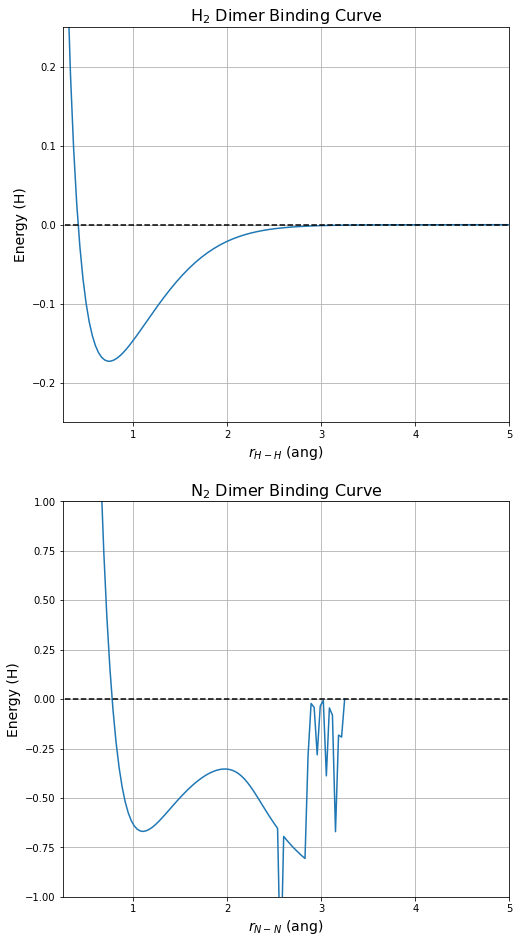

In [21]:
#plot dimer calculation energies
h2r = read('/home/awills/Documents/Research/swxcd/aegis/dimers/h2/results.traj', ':')
#n2r = read('/home/awills/Documents/Research/swxcd/aegis/dimers/n2/results.traj', ':')
n2s = sorted([i for i in os.listdir('/home/awills/Documents/Research/swxcd/aegis/dimers/n2') if 'N2.traj' in i],
            key=lambda x: int(x.split('_')[0]))
n2r = []
for i in n2s:
    n2r += read(os.path.join('/home/awills/Documents/Research/swxcd/aegis/dimers/n2/', i), ':')
hds = []
hes = []
nds = []
nes = []
for idx, at in enumerate(h2r):
    d = at.positions[0, -1] - at.positions[1, -1]
    hds.append(d)
    hes.append(at.calc.results['energy'])
for idx, at in enumerate(n2r):
    d = at.positions[0, -1] - at.positions[1, -1]
    nds.append(d)
    nes.append(at.calc.results['energy'])
hes = np.array(hes)
nes = np.array(nes)
f = plt.figure(figsize=(8,16))
axh = f.add_subplot(211)
axn = f.add_subplot(212)
axh.plot(hds, hes-hes[-1])
axn.plot(nds, nes-nes[-1])
axh.plot(hds, np.zeros_like(hds), 'k--')
axn.plot(hds, np.zeros_like(hds), 'k--')

axh.set_title('H$_2$ Dimer Binding Curve', fontsize=16)
axh.set_ylim(-.25,.25)
axh.set_xlim(0.25, 5)
axh.grid()
axh.set_ylabel('Energy (H)', fontsize=14)
axh.set_xlabel('$r_{H-H}$ (ang)', fontsize=14)

axn.set_ylim(-1,1)
axn.set_xlim(0.25, 5)
axn.grid()
axn.set_ylabel('Energy (H)', fontsize=14)
axn.set_xlabel('$r_{N-N}$ (ang)', fontsize=14)
axn.set_title('N$_2$ Dimer Binding Curve', fontsize=16)

In [6]:
n2r

[[Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))],
 [Atoms(symbols='N2', pbc=False, calcu

In [34]:
for idx, at in enumerate(ndimers):
    print(idx, at, at.info, at.positions)

0 Atoms(symbols='N2', pbc=False) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False} [[ 0.    0.    0.25]
 [ 0.    0.   -0.25]]
1 Atoms(symbols='N2', pbc=False) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False} [[ 0.       0.       0.40625]
 [ 0.       0.      -0.40625]]
2 Atoms(symbols='N2', pbc=False) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False} [[ 0.        0.        0.549396]
 [ 0.        0.       -0.549396]]
3 Atoms(symbols='N2', pbc=False) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False} [[ 0.      0.      0.5625]
 [ 0.      0.     -0.5625]]
4 Atoms(symbols='N2', pbc=False) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False} [[ 0.       0.       0.71875]
 [ 0.       0.      -0.71875]]
5 Atoms(symbols='N2', pbc=False) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False} [[ 0.     0.     0.875]
 [ 0.     0.    -0.875]]
6 Atoms(symbols='N2', 

In [4]:
for idx, at in enumerate(subat):
    try:
        print(idx, at, at.calc, at.info, at.calc.results)
    except:
        print(idx, at, at.info)

0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=-0.17434014967795244) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False} {'energy': -0.17434014967795244}
1 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=-0.36405261150717777) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False} {'energy': -0.36405261150717777}
2 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=-0.22243004393513086) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False} {'energy': -0.22243004393513086}
3 Atoms(symbols='F', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=-99.7339) {'spin': 1, 'sym': False, 'grid_level': 4, 'basis': '6-311+G*', 'pol': False} {'energy': -99.7339}
4 Atoms(symbols='H', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(

In [4]:
calcs = read('/home/awills/Documents/Research/swxcd/aegis/xcd_ccsdt/calc_results.traj', ':')
rxn = read('/home/awills/Documents/Research/swxcd/aegis/xcd_ccsdt/haunschild_scan_reaction.traj', ':')
energies = np.loadtxt('/home/awills/Documents/Research/xcdiff/data/ref/6-311/energies')[:, 1]
for idx, i in enumerate(rxn):
    calc = calcs[idx]
    print('+++', idx, calc, calc.calc.results['energy'])
    #ref atomization or total atomic energy
    e = energies[idx]
    eH = e#/Hartree
    eV = e*Hartree
    print("++", e, eH)
    i.info['energy'] = eH
    i.info['atomization'] = eH
    i.info['atomization_ev'] = eV
    i.info['atomization_H'] = eH
    print("---", i, e)
    calc.info = i.info
    calc.info['energy'] = calc.calc.results['energy']
    #overwrite calculator to use reference energy
    calc.calc.results['energy'] = e
    calc.info['target_energy'] = e
    if len(calc.positions) > 1:
        #if greater than 1 atom, use total energy from calculation
        calc.info['calc_energy'] = calc.info['energy']
        calc.info['e_calc'] = calc.info['energy']
    else:
        #else use reference energy for single atom
        try:
            calc.info['calc_energy'] = i.calc.results['energy']
            calc.info['e_calc'] = i.calc.results['energy']
        except:
            #no calc on single atoms in reaction pathways, just use ccsdt energies
            calc.info['calc_energy'] = calc.info['energy']
            calc.info['e_calc'] = calc.info['energy']
    
    calc.info['atomization'] = eH
    calc.info['atomization_ev'] = eV
    calc.info['atomization_H'] = eH
    print("--", calc.calc.results, calc.info)
write('/home/awills/Documents/Research/swxcd/aegis/xcd_ccsdt/calc_ref_results.traj', calcs)

+++ 0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) -1.1723488681184564
++ -0.17434014967795244 -0.17434014967795244
--- Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) -0.17434014967795244
-- {'energy': -0.17434014967795244} {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'energy': -1.1723488681184564, 'atomization': -0.17434014967795244, 'atomization_ev': -4.7440371124327285, 'atomization_H': -0.17434014967795244, 'target_energy': -0.17434014967795244, 'calc_energy': -1.1723488681184564, 'e_calc': -1.1723488681184564}
+++ 1 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) -109.4191625803428
++ -0.36405261150717777 -0.36405261150717777
--- Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) -0.36405261150717777
-- {'energy': -0.36405261150717777} {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False, 'energy': -109.4191625803428, 'atomization': -0.364052611

In [5]:
for idx, at in enumerate(calcs):
    print(idx, at, at.info)

0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'energy': -1.1723488681184564, 'target_energy': -0.17434014967795244, 'calc_energy': -1.1723488681184564, 'atomization': -0.17434014967795244, 'atomization_ev': -4.7440371124327285, 'atomization_H': -0.17434014967795244}
1 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False, 'energy': -109.4191625803428, 'target_energy': -0.36405261150717777, 'calc_energy': -109.4191625803428, 'atomization': -0.36405261150717777, 'atomization_ev': -9.906376144900815, 'atomization_H': -0.36405261150717777}
2 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False, 'energy': -107.30594204758019, 'target_energy': -0.22243004393513086, 'calc_energy': -107.30594204758019, 'atomizat

In [6]:
calcs = read('/home/awills/Documents/Research/swxcd/aegis/test_subset2/calcresults.traj', ':')
for idx, i in enumerate(subat):
    calc = calcs[idx]
    print('+++', idx, calc, calc.calc.results['energy'])
    ce = calc.calc.results['energy']
    e = i.calc.results['energy']
    eH = e#/Hartree
    eV = e*Hartree
    calc.info = i.info
    print("++", e, eH)
    i.info['energy'] = eH
    i.info['atomization'] = eH
    i.info['atomization_ev'] = eV
    i.info['atomization_H'] = eH
    print("---", i, i.calc.results)
    calc.info['energy'] = calc.calc.results['energy']
    #overwrite calculator to use reference energy
    calc.calc.results['energy'] = i.calc.results['energy']
    calc.info['target_energy'] = i.calc.results['energy']
    if len(calc.positions) > 1:
        #if greater than 1 atom, use total energy from calculation
        calc.info['calc_energy'] = calc.info['energy']
        calc.info['e_calc'] = calc.info['energy']
    else:
        #else use reference energy for single atom
        calc.info['calc_energy'] = i.calc.results['energy']
        calc.info['e_calc'] = i.calc.results['energy']
    calc.info['atomization'] = eH
    calc.info['atomization_ev'] = eV
    calc.info['atomization_H'] = eH
    print("--", calc.calc.results, calc.info)
write('/home/awills/Documents/Research/swxcd/aegis/test_subset2/caresults.traj', calcs)

+++ 0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) -1.1723488681184564
++ -0.17434014967795244 -0.17434014967795244
--- Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -0.17434014967795244}
-- {'energy': -0.17434014967795244} {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'energy': -1.1723488681184564, 'atomization': -0.17434014967795244, 'atomization_ev': -4.7440371124327285, 'atomization_H': -0.17434014967795244, 'target_energy': -0.17434014967795244, 'calc_energy': -1.1723488681184564, 'e_calc': -1.1723488681184564}
+++ 1 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) -109.41916258239198
++ -0.36405261150717777 -0.36405261150717777
--- Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) {'energy': -0.36405261150717777}
-- {'energy': -0.36405261150717777} {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False, 'energy': -109.41916258239198, '

In [26]:
test = read('/home/awills/Documents/Research/swxcd/aegis/test_subset2/caresults.traj', ':')

[i.info for i in test]

[{'H2': True,
  'name': 'Dihydrogen',
  'n_rad': 2,
  'n_ang': 10,
  'pol': False,
  'energy': -1.1723488681184584,
  'target_energy': -0.17434014967795244,
  'calc_energy': -1.1723488681184584,
  'atomization': -0.17434014967795244,
  'atomization_ev': -4.7440371124327285,
  'atomization_H': -0.17434014967795244},
 {'N2': True,
  'name': 'Dinitrogen',
  'n_rad': 6,
  'n_ang': 10,
  'pol': False,
  'energy': -109.41916258306912,
  'target_energy': -0.36405261150717777,
  'calc_energy': -109.41916258306912,
  'atomization': -0.36405261150717777,
  'atomization_ev': -9.906376144900815,
  'atomization_H': -0.36405261150717777},
 {'LiF': True,
  'name': 'Lithium fluoride',
  'n_rad': 3,
  'n_ang': 15,
  'pol': False,
  'energy': -107.30594205271949,
  'target_energy': -0.22243004393513086,
  'calc_energy': -107.30594205271949,
  'atomization': -0.22243004393513086,
  'atomization_ev': -6.052629788935811,
  'atomization_H': -0.22243004393513086},
 {'spin': 1,
  'sym': False,
  'grid_level':

In [19]:
[i.info for i in calcs]

[{'H2': True,
  'name': 'Dihydrogen',
  'n_rad': 2,
  'n_ang': 10,
  'pol': False,
  'energy': -1.1723488681184584,
  'atomization': -0.17434014967795244,
  'atomization_ev': -4.7440371124327285,
  'atomization_H': -0.17434014967795244},
 {'N2': True,
  'name': 'Dinitrogen',
  'n_rad': 6,
  'n_ang': 10,
  'pol': False,
  'energy': -109.41916258306912,
  'atomization': -0.36405261150717777,
  'atomization_ev': -9.906376144900815,
  'atomization_H': -0.36405261150717777},
 {'LiF': True,
  'name': 'Lithium fluoride',
  'n_rad': 3,
  'n_ang': 15,
  'pol': False,
  'energy': -107.30594205271949,
  'atomization': -0.22243004393513086,
  'atomization_ev': -6.052629788935811,
  'atomization_H': -0.22243004393513086},
 {'spin': 1,
  'sym': False,
  'grid_level': 4,
  'basis': '6-311+G*',
  'pol': False,
  'energy': -99.64090370770167,
  'atomization': -99.7339,
  'atomization_ev': -2713.8976526156403,
  'atomization_H': -99.7339},
 {'spin': 1,
  'sym': False,
  'grid_level': 1,
  'basis': '6-31

In [6]:
for idx, at in enumerate(refrxnw):
    try:
        print(idx, at, at.calc, at.info, at.calc.results)
    except:
        print(idx, at, at.info)

0 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=-0.17434014967795244) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False} {'energy': -0.17434014967795244}
1 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=-0.36405261150717777) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False} {'energy': -0.36405261150717777}
2 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=-0.22243004393513086) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False} {'energy': -0.22243004393513086}
3 Atoms(symbols='CNH', pbc=False, calculator=SinglePointCalculator(...)) SinglePointCalculator(energy=-0.4993221026004529) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False} {'energy': -0.4993221026004529}
4 Atoms(symbols='CO2', pbc=False, calculator=SinglePoint

In [7]:
train_formulas = ['H2', 'N2', 'LiF', 'CNH', 'CO2', 'F2', 'C2H2', 'OC', 'LiH', 'Na2', 'NO', 'CH', 'OH',
                 'NO2', 'NH', 'O3', 'N2O', 'CH3', 'CH2', 'H2O', 'NH3']
closed_formulas = ['H2', 'N2', 'LiF', 'CNH', 'CO2', 'F2', 'C2H2', 'OC', 'LiH', 'Na2',
                  'NO2', 'NH', 'O3', 'N2O', 'CH3', 'CH2', 'H2O', 'NH3']
open_formulas = ['NO', 'CH', 'OH']
train_idcs = []
for idx, atom in enumerate(g297ref):
    symb = str(atom.symbols)
    form = atom.get_chemical_formula()
    if (symb in train_formulas) or (form in train_formulas):
        #Does reference traj match expected shell occupation?
        expected_shell = True if ( (symb in open_formulas) or (form in open_formulas) ) else False
        oc = atom.info['openshell']
        match = expected_shell == oc
        print(idx, atom.symbols, atom.get_chemical_formula(), atom.calc.results['energy'], match, atom.calc)
        train_idcs.append(idx)

0 OC CO 11.271868661369064 True SinglePointCalculator(energy=11.271868661369064)
2 H2 H2 4.7440371124327285 True SinglePointCalculator(energy=4.7440371124327285)
11 CO2 CO2 16.934698271599974 True SinglePointCalculator(energy=16.934698271599974)
15 OH2 H2O 10.1045409791693 True SinglePointCalculator(energy=10.1045409791693)
18 CNH CHN 13.58724648435963 True SinglePointCalculator(energy=13.58724648435963)
21 N2O N2O 11.74997241685051 True SinglePointCalculator(energy=11.74997241685051)
23 NO2 NO2 9.888549601232311 False SinglePointCalculator(energy=9.888549601232311)
25 LiF FLi 6.052629788935811 True SinglePointCalculator(energy=6.052629788935811)
26 LiH HLi 2.510951589865373 True SinglePointCalculator(energy=2.510951589865373)
29 Na2 Na2 0.7439472700727967 True SinglePointCalculator(energy=0.7439472700727967)
58 NH3 H3N 12.913776247394873 True SinglePointCalculator(energy=12.913776247394873)
83 NO NO 6.625670253721614 True SinglePointCalculator(energy=6.625670253721614)
84 NH HN 3.5966

In [5]:
print(len(train_formulas), len(train_idcs))

21 22


In [6]:
print(g297ref[105].info , g297ref[106].info)

{'CH2': True, 'name': 'Singlet carbene', 'openshell': True} {'CH2': True, 'name': 'Triplet carbene', 'openshell': True}


Methylene ($\mathrm{CH_2}$) matches twice -- the singlet and triplet states. Since it is assumed to be closed-shell in training, we train on the singlet state.

In [7]:
train_idcs = [i for i in train_idcs if i != 106]

In [8]:
for idx in train_idcs:
    print(g297ref[idx].info, g297mol[idx][1].spin)

{'CO': True, 'name': 'Carbon monoxide', 'openshell': False} 0
{'H2': True, 'name': 'Dihydrogen', 'openshell': False} 0
{'CO2': True, 'name': 'Carbon dioxide', 'openshell': False} 0
{'H2O': True, 'name': 'Water', 'openshell': False} 0
{'CNH': True, 'name': 'Hydrogen cyanide', 'openshell': False} 0
{'N2O': True, 'name': 'Nitrous oxide', 'openshell': False} 0
{'NO2': True, 'name': 'Nitrogen dioxide', 'openshell': True} 1
{'LiF': True, 'name': 'Lithium fluoride', 'openshell': False} 0
{'LiH': True, 'name': 'Lithium hydride', 'openshell': False} 0
{'Na2': True, 'name': 'Disodium', 'openshell': False} 0
{'NH3': True, 'name': 'Ammonia', 'openshell': False} 0
{'NO': True, 'name': 'Nitric oxide', 'openshell': True} 1
{'NH': True, 'name': 'Imidogen', 'openshell': True} 0
{'C2H2': True, 'name': 'Acetylene', 'openshell': False} 0
{'CH2': True, 'name': 'Singlet carbene', 'openshell': True} 0
{'HO': True, 'name': 'Hydroxyl radical', 'openshell': True} 1
{'CH': True, 'name': 'Methylidyne radical', 'o

## BH76 reactions coded in specific way.

In [2]:
rxn = read('/home/awills/Documents/Research/xcdiff/data/haunschild_scan_reaction.traj', ':')
rxn_mol = []
for at in rxn:
    print(at, at.info)
    _, mol = ase_atoms_to_mol(at, charge=at.info.get('charge', 0), spin=at.info.get('spin', None))
    mol.verbose = 4
    rxn_mol.append(mol)
rxn_mf = []
for imol in range(len(rxn_mol)):
    at = rxn[imol]
    mol = rxn_mol[imol]
    pol = at.info.get('pol', True)
    rxn_mf.append(gen_mf_mol(mol, xc='SCAN', pol=pol, grid_level=at.info.get('grid_level', 3)))
scan = read('/home/awills/Documents/Research/xcdiff/data/haunschild_scan.traj', ':')

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False}
Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False}
Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False}
Atoms(symbols='CNH', pbc=False, calculator=SinglePointCalculator(...)) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False}
Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12}
Atoms(symbols='Cl2', pbc=False, calculator=SinglePointCalculator(...)) {'Cl2': True, 'name': 'Dichlorine', 'n_rad': 3, 'n_ang': 20, 'spin': 0, 'pol': True}
Atoms(symbols='F2', pbc=False, calculator=SinglePointCalculator(...)) {'F2': True, 'name': 'Difluorine', '

In [4]:
#H2 Ind = 0
h2 = rxn[0]
print(h2.info)
h2m = rxn_mol[0]
print(h2, h2.get_positions())
#h2mf = rxn_mf[0][0]
h2mf = gen_mf_mol(h2m, xc='scan', pol=False, grid_level=h2.info.get('grid_level', 5))[0]
h2mf.max_cycle = 250
#h2mf.chkfile = '/home/awills/Documents/Research/swxcd/aegis/hscanrxn2/0_H2.chkpt'
#h2mf.init_guess = 'chkfile'
h2mf.kernel()

{'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False}
Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) [[ 0.        0.        0.371395]
 [ 0.        0.       -0.371395]]
Building grids...
tot grids = 47536
METHOD GENERATED: <function RKS at 0x7f725a6a0c20>


******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 250
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/dpyscfl/notebooks/tmpifizk814
max_memory 4000 MB (current use 551 MB)
XC library pyscf.dft.libxc version 5.1.7
    S. Lehtola, C. Steigemann, M. J. Oliveira, and M. A. Marques, SoftwareX 7, 1 (2018)
XC functionals = scan
    J. Sun, A. Ruzsinszky, and J. P. Perdew, Phys. Rev. Lett. 115, 036402 (2015)
    J. Sun, A. Ruzsinszky, a

-1.171295094776314

In [4]:
for at in rxn:
    print(at, at.info)
    print()

Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False}

Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False}

Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False}

Atoms(symbols='CNH', pbc=False, calculator=SinglePointCalculator(...)) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False}

Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12}

Atoms(symbols='Cl2', pbc=False, calculator=SinglePointCalculator(...)) {'Cl2': True, 'name': 'Dichlorine', 'n_rad': 3, 'n_ang': 20, 'spin': 0, 'pol': True}

Atoms(symbols='F2', pbc=False, calculator=SinglePointCalculator(...)) {'F2': True, 'name': 'Difluori

In [9]:
for at in rxn:
    if not at.info.get('grid_level'):
        print(at.get_chemical_formula(), at.calc, at.info)

H2 SinglePointCalculator(energy=4.7440371124327285) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False}
N2 SinglePointCalculator(energy=9.906376144900815) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False}
FLi SinglePointCalculator(energy=6.052629788935811) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False}
CHN SinglePointCalculator(energy=13.58724648435963) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False}
CO2 SinglePointCalculator(energy=16.934698271599974) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12}
Cl2 SinglePointCalculator(energy=2.5726189938349067) {'Cl2': True, 'name': 'Dichlorine', 'n_rad': 3, 'n_ang': 20, 'spin': 0, 'pol': True}
F2 SinglePointCalculator(energy=1.6822245946714354) {'F2': True, 'name': 'Difluorine', 'n_rad': 8, 'n_ang': 20, 'spin': 0, 'pol': True}
O2 SinglePointCalculator(energy=5.24307669245509) {'O2': True, 'name': 'Dioxygen'

In [7]:
for at in rxn:
    if at.info.get('sym', False):
        print(at.get_chemical_formula(), at.calc, at.info)

`prep_data.py` has been run on these molecules, and on the charge/neutral atoms with mixing flagged. However, some are not needed in training -- O2, for instance.

In [5]:
for i,at in enumerate(rxn):
    form = at.get_chemical_formula()
    symb = str(at.symbols)
    if (form not in train_formulas) and (symb not in train_formulas):
        print(at.get_chemical_formula(), at.info)

NameError: name 'train_formulas' is not defined

In [6]:
frac = read('/home/awills/Documents/Research/swxcd/aegis/fc0fcp/results.traj', ':')

In [7]:
for at in frac:
    at.info['sym'] = False
    print(at.get_chemical_formula(), at.calc.results['energy']/Hartree, at.info)

H -0.49981791563042 {'hydrogen': True, 'sym': False}
He -0.20671372341445055 {'helium': True, 'sym': False}
Li -7.447596712081985 {'lithium': True, 'sym': False}
Be -14.633911855193977 {'beryllium': True, 'sym': False}
B -24.61544820453375 {'boron': True, 'sym': False}
C -37.74566457222009 {'carbon': True, 'sym': False}
N -54.43322059135443 {'nitrogen': True, 'sym': False}
O -74.91233523925945 {'oxygen': True, 'sym': False}
F -99.64090370770165 {'fluorine': True, 'sym': False}
Ne -128.82330439729932 {'neon': True, 'sym': False}
Na -162.0021435597149 {'sodium': True, 'sym': False}
Mg -199.7861347977223 {'magnesium': True, 'sym': False}
Al -242.08410819638007 {'aluminum': True, 'sym': False}
Si -289.05970250529685 {'silicon': True, 'sym': False}
P -340.9156246185097 {'phosphorous': True, 'sym': False}
S -397.7590577080532 {'sulfur': True, 'sym': False}
Cl -459.7548399975847 {'chlorine': True, 'sym': False}
Ar -527.1331280012964 {'argon': True, 'sym': False}
H 0.0 {'hydrogen': True, 'char

In [12]:
ats = read('/home/awills/Documents/Research/swxcd/data/xcdsymfrac_mg1/results.traj', ':')
ds = MemDatasetRead('/home/awills/Documents/Research/swxcd/data/hscanrxnsym/')
for idx, d in enumerate(ds):
    print(idx, ats[idx].get_chemical_formula(), d[1]['e_base'])

0 H2 5.778509382153771
1 N2 -109.51975181643904
2 FLi -107.425408025984


KeyboardInterrupt: 

In [56]:
write('/home/awills/Documents/Research/swxcd/aegis/fc0fcp/results.traj', frac)

In [6]:
for i,at in enumerate(frac):
    form = at.get_chemical_formula()
    symb = at.symbols
    if not ((form in train_formulas) or (symb in train_formulas)):
        print(at.get_chemical_formula(), at.info)

NameError: name 'frac' is not defined

The prepared data (on my device) are respectively stored in `/home/awills/Documents/Research/swxcd/data/hscanrxnsym` and `/home/awills/Documents/Research/swxcd/data/fc0fcp`, so we want to create a new directory and symlink the previous files in an appropriately indexed manner, with the caveat that the prior folder used the old `prep_data.py` script, so the inputs are stored differently.

In [5]:
def cat_traj_write(traj1, traj2, writeloc, writefile='results.traj', traj1inf={}, traj2inf={}):
    newtraj = []
    for at in traj1:
        if traj1inf:
            at.info = {**at.info, **traj1inf}
        newtraj.append(at)
    for at in traj2:
        if traj2inf:
            at.info = {**at.info, **traj2inf}
        newtraj.append(at)
    write(filename=os.path.join(writeloc, writefile), images=newtraj)
rxn = read('/home/awills/Documents/Research/xcdiff/data/haunschild_scan_reaction.traj', ':')
frac = read('/home/awills/Documents/Research/swxcd/aegis/fc0fcp/results.traj', ':')
cat_traj_write(rxn, frac, '/home/awills/Documents/Research/swxcd/data/xcdsymfrac_mg1', traj1inf = {"oldprep":False},
              traj2inf= {'supp':True, 'sym':False})

Symlink: 
```
ln -s source_file symbolic_link
```

In [7]:
def ln_cat_prep_dirs(traj1, traj2, traj1dat, traj2dat, destdir):
    n_traj1 = np.load(traj1dat+'/data_len.npy')
    n_traj2 = np.load(traj2dat+'/data_len.npy')
    n_traj_cat = n_traj1+n_traj2
    print(n_traj_cat)
    np.save(destdir+'/data_len.npy', n_traj_cat)
    nidx = 0
    for idx, at in enumerate(traj1):
        pcklp = 'data_{}.pckl'.format(idx)
        fp = os.path.join(traj1dat, pcklp)
        sp = os.path.join(destdir, pcklp)
        os.symlink(fp, sp)
        nidx += 1
    for idx, at in enumerate(traj2):
        fpcklp = 'data_{}.pckl'.format(idx)
        spcklp = 'data_{}.pckl'.format(nidx)
        fp = os.path.join(traj2dat, fpcklp)
        sp = os.path.join(destdir, spcklp)
        os.symlink(fp, sp)
        nidx += 1

In [8]:
ln_cat_prep_dirs(rxn, frac, '/home/awills/Documents/Research/swxcd/data/hscanrxnsym_mg1',
                '/home/awills/Documents/Research/swxcd/data/fc0fcp_mg1', 
                 destdir='/home/awills/Documents/Research/swxcd/data/xcdsymfrac_mg1')

102


In [16]:
len(rxn+frac)

102

In [4]:
rxnfrac = read('/home/awills/Documents/Research/swxcd/data/xcdsymfrac_mg1/results.traj', ':')

In [5]:
for i,at in enumerate(rxnfrac):
    try:
        print(at.get_chemical_formula(), at.calc, at.info)
    except:
        print(at.get_chemical_formula(), at.info)

H2 SinglePointCalculator(energy=4.7440371124327285) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False, 'oldprep': False}
N2 SinglePointCalculator(energy=9.906376144900815) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False, 'oldprep': False}
FLi SinglePointCalculator(energy=6.052629788935811) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False, 'oldprep': False}
CHN SinglePointCalculator(energy=13.58724648435963) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False, 'oldprep': False}
CO2 SinglePointCalculator(energy=16.934698271599974) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12, 'oldprep': False}
Cl2 SinglePointCalculator(energy=2.5726189938349067) {'Cl2': True, 'name': 'Dichlorine', 'n_rad': 3, 'n_ang': 20, 'spin': 0, 'pol': True, 'oldprep': False}
F2 SinglePointCalculator(energy=1.6822245946714354) {'F2': True, 'name': 'Difluorine', 'n_rad': 8, 'n_ang': 2

In [11]:
atoms = refrxnw
print("PARSING NON-ATOMIC NON-REACTION MOLECULES")
molecules = {'{:3d}'.format(idx) + ''.join(a.get_chemical_symbols()): [idx] for idx, a in enumerate(atoms) if len(a.positions) > 1 and not a.info.get('reaction') }
print(molecules)
print("PARSING NEUTRAL, PURE NON-REACTION ATOMS. CHARGE FLAG NOT SET.")
pure_atoms = {''.join(a.get_chemical_symbols()): [idx] for idx, a in enumerate(atoms) if len(a.positions) == 1 and not a.info.get('reaction') and not a.info.get('fractional') and not a.info.get('charge') and not a.info.get('supp')}
print(pure_atoms)
molecules.update(pure_atoms)
print("PARSING SUPPLEMENTAL NEUTRAL, PURE ATOMS (FROM FRAC DATASET)")
n_atoms = {''.join(a.get_chemical_symbols())+'_n0': [idx] for idx, a in enumerate(atoms) if len(a.positions)==1 and a.info.get('supp') and not a.info.get('charge')}
#print(n_atoms)
#molecules.update(n_atoms)
print("PARSING SUPPLEMENTAL CHARGED, PURE ATOMS")
c_atoms = {''.join(a.get_chemical_symbols())+'_c{}'.format(a.info['charge']): [idx] for idx, a in enumerate(atoms) if len(a.positions)==1 and a.info.get('supp') and a.info.get('charge')}
#print(c_atoms)
#molecules.update(c_atoms)
print("PARSING SUPPLEMENTAL FRACTIONAL ATOMS")
frac_atoms = {''.join(a.get_chemical_symbols())+'_f{}'.format(a.info['fractional']): [idx] for idx, a in enumerate(atoms) if len(a.positions)==1 and a.info.get('supp') and a.info.get('fractional')}
#print(frac_atoms)
#molecules.update(frac_atoms)
def cat_dict(dicts, keysplit='_'):
    retdct = {k:[] for k in list(dicts[0].keys())}
    rkeys = sorted(list(retdct.keys()))
    for didx,dct in enumerate(dicts):
        dkeys = sorted(list(dct.keys()))
        for dk in dkeys:
            mkey = [mk for mk in rkeys if dk.split(keysplit)[0] in mk.split(keysplit)[0]][0]
            retdct[mkey] += (dct[dk])
    return retdct
fracdct = cat_dict([frac_atoms, n_atoms, c_atoms])
molecules.update(frac_atoms)

def split(el):
        import re
        #Splits a string on capital letter sequences
        res_list = [s for s in re.split("([A-Z][^A-Z]*)", el) if s]
        return res_list

for molecule in molecules:
    comp = []
    #ignore _ atoms, charged or fractional
    if '_' in molecule:
        continue
    for a in split(molecule[3:]):
        comp.append(pure_atoms[a][0])
    molecules[molecule] += comp
a_count = {idx: len(at.positions) for idx,at in enumerate(atoms)}
#a_count = {a: np.sum([a in molecules[mol] for mol in molecules]) for a in np.unique([m  for mol in molecules for m in molecules[mol]])}
print("PARSING REACTIONS")
reactions = {}
for idx, a in enumerate(atoms):
    #atom must have reaction flag
    if not a.info.get('reaction'): continue
    #and atom must not be a reactant
    if a.info.get('reaction') == 'reactant': continue
    reactions['{:3d}'.format(idx) + ''.join(a.get_chemical_symbols())] = \
        [idx] + [idx + i for i in np.arange(-a.info.get('reaction'),0,1).astype(int)]
print(reactions)
a_count = {a: np.sum([a in molecules[mol] for mol in molecules]) for a in np.unique([m  for mol in molecules for m in molecules[mol]])}
molecules.update(reactions)
print("MOLECULES TO TRAIN ON")
print(molecules)
#a_count = {idx: len(at.positions) for idx,at in enumerate(atoms)}
print(a_count)
a_count = {a: np.sum([a in molecules[mol] for mol in molecules]) for a in np.unique([m  for mol in molecules for m in molecules[mol]])}
print(a_count)

PARSING NON-ATOMIC NON-REACTION MOLECULES
{'  0HH': [0], '  1NN': [1], '  2LiF': [2], '  3CNH': [3], '  4COO': [4], '  5ClCl': [5], '  6FF': [6], '  7OO': [7], '  8CCHH': [8], '  9OC': [9], ' 10ClH': [10], ' 11LiH': [11], ' 12NaNa': [12], ' 21NO': [21], ' 22NOO': [22], ' 23NH': [23], ' 24OOO': [24], ' 25NNO': [25], ' 26CHHH': [26], ' 27CHH': [27], ' 28OHH': [28], ' 29NHHH': [29], ' 30OH': [30], ' 31CH': [31]}
PARSING NEUTRAL, PURE NON-REACTION ATOMS. CHARGE FLAG NOT SET.
{'C': [13], 'Cl': [14], 'F': [15], 'H': [16], 'Li': [17], 'N': [18], 'Na': [19], 'O': [20]}
PARSING SUPPLEMENTAL NEUTRAL, PURE ATOMS (FROM FRAC DATASET)
PARSING SUPPLEMENTAL CHARGED, PURE ATOMS
PARSING SUPPLEMENTAL FRACTIONAL ATOMS
PARSING REACTIONS
{' 34HONN': [34, 32, 33], ' 37HONN': [37, 35, 36], ' 40CHHHHO': [40, 38, 39], ' 43HFF': [43, 41, 42], ' 45C': [45, 44], ' 47Li': [47, 46], ' 49OHHOHH': [49, 48]}
MOLECULES TO TRAIN ON
{'  0HH': [0, 16, 16], '  1NN': [1, 18, 18], '  2LiF': [2, 17, 15], '  3CNH': [3, 13, 18, 

In [8]:
[[a in molecules[mol] for mol in molecules] for a in np.unique([m  for mol in molecules for m in molecules[mol]])]

[[True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  

In [17]:
{a: np.sum([a in molecules[mol] for mol in molecules]) for a in np.unique([m  for mol in molecules for m in molecules[mol]])}

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 8,
 14: 3,
 15: 3,
 16: 13,
 17: 3,
 18: 8,
 19: 2,
 20: 10,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1}

In [21]:
refrxnw

Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...))

In [8]:
a_count = {idx: len(at.positions) for idx,at in enumerate(atoms)}
print(a_count)

{0: 2, 1: 2, 2: 2, 3: 3, 4: 3, 5: 2, 6: 2, 7: 2, 8: 4, 9: 2, 10: 2, 11: 2, 12: 2, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 2, 22: 3, 23: 2, 24: 3, 25: 3, 26: 4, 27: 3, 28: 3, 29: 4, 30: 2, 31: 2, 32: 1, 33: 3, 34: 4, 35: 2, 36: 2, 37: 4, 38: 2, 39: 4, 40: 6, 41: 2, 42: 1, 43: 3, 44: 1, 45: 1, 46: 1, 47: 1, 48: 6, 49: 6}


In [19]:
np.arange(-rxnw[34].info.get('reaction'),0,1)

array([-2, -1])

In [27]:
def cat_dict(dicts, keysplit='_'):
    retdct = {k:[] for k in list(dicts[0].keys())}
    rkeys = sorted(list(retdct.keys()))
    for didx,dct in enumerate(dicts):
        dkeys = sorted(list(dct.keys()))
        for dk in dkeys:
            mkey = [mk for mk in rkeys if dk.split(keysplit)[0] in mk.split(keysplit)[0]][0]
            retdct[mkey] += (dct[dk])
    return retdct

In [28]:
cat_dict([frac_atoms, n_atoms, c_atoms])

{'H_f0.5': [84, 84, 66],
 'He_f0.5': [85, 85, 67],
 'Li_f0.5': [86, 86, 68],
 'Be_f0.5': [87, 87, 69],
 'B_f0.5': [88, 88, 70],
 'C_f0.5': [89, 89, 71],
 'N_f0.5': [90, 90, 72],
 'O_f0.5': [91, 91, 73],
 'F_f0.5': [92, 92, 74],
 'Ne_f0.5': [93, 93, 75],
 'Na_f0.5': [94, 94, 76],
 'Mg_f0.5': [95, 95, 77],
 'Al_f0.5': [96, 96, 78],
 'Si_f0.5': [97, 97, 79],
 'P_f0.5': [98, 98, 80],
 'S_f0.5': [99, 99, 81],
 'Cl_f0.5': [100, 100, 82],
 'Ar_f0.5': [101, 101, 83]}

In [45]:
molecules

{'  0HH': [0, 16, 16],
 '  1NN': [1, 18, 18],
 '  2LiF': [2, 17, 15],
 '  3CNH': [3, 13, 18, 16],
 '  4COO': [4, 13, 20, 20],
 '  5ClCl': [5, 14, 14],
 '  6FF': [6, 15, 15],
 '  7OO': [7, 20, 20],
 '  8CCHH': [8, 13, 13, 16, 16],
 '  9OC': [9, 20, 13],
 ' 10ClH': [10, 14, 16],
 ' 11LiH': [11, 17, 16],
 ' 12NaNa': [12, 19, 19],
 ' 21NO': [21, 18, 20],
 ' 22NOO': [22, 18, 20, 20],
 ' 23NH': [23, 18, 16],
 ' 24OOO': [24, 20, 20, 20],
 ' 25NNO': [25, 18, 18, 20],
 ' 26CHHH': [26, 13, 16, 16, 16],
 ' 27CHH': [27, 13, 16, 16],
 ' 28OHH': [28, 20, 16, 16],
 ' 29NHHH': [29, 18, 16, 16, 16],
 ' 30OH': [30, 20, 16],
 ' 31CH': [31, 13, 16],
 'C': [13],
 'Cl': [14],
 'F': [15],
 'H': [16],
 'Li': [17],
 'N': [18],
 'Na': [19],
 'O': [20],
 'H_n0': [84],
 'He_n0': [85],
 'Li_n0': [86],
 'Be_n0': [87],
 'B_n0': [88],
 'C_n0': [89],
 'N_n0': [90],
 'O_n0': [91],
 'F_n0': [92],
 'Ne_n0': [93],
 'Na_n0': [94],
 'Mg_n0': [95],
 'Al_n0': [96],
 'Si_n0': [97],
 'P_n0': [98],
 'S_n0': [99],
 'Cl_n0': [100]

# Addition of HB-PT Water to Original Dataset

In [4]:
rxn = read('/home/awills/Documents/Research/xcdiff/data/haunschild_scan_reaction.traj', ':')


/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


In [5]:
rxn

[Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CNH', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='CO2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='Cl2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='F2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='O2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='C2H2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='OC', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='ClH', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='LiH', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='Na2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='C', pbc=False),
 Atoms(symbols='Cl', pb

In [7]:
for i,at in enumerate(rxn):
    try:
        print(at.get_chemical_formula(), at.calc, at.info)
    except:
        print(at.get_chemical_formula(), at.info)

H2 SinglePointCalculator(energy=4.7440371124327285) {'H2': True, 'name': 'Dihydrogen', 'n_rad': 2, 'n_ang': 10, 'pol': False}
N2 SinglePointCalculator(energy=9.906376144900815) {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False}
FLi SinglePointCalculator(energy=6.052629788935811) {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False}
CHN SinglePointCalculator(energy=13.58724648435963) {'CNH': True, 'name': 'Hydrogen cyanide', 'n_rad': 2, 'n_ang': 8, 'spin': 0, 'pol': False}
CO2 SinglePointCalculator(energy=16.934698271599974) {'CO2': True, 'name': 'Carbon dioxide', 'n_rad': 7, 'n_ang': 12}
Cl2 SinglePointCalculator(energy=2.5726189938349067) {'Cl2': True, 'name': 'Dichlorine', 'n_rad': 3, 'n_ang': 20, 'spin': 0, 'pol': True}
F2 SinglePointCalculator(energy=1.6822245946714354) {'F2': True, 'name': 'Difluorine', 'n_rad': 8, 'n_ang': 20, 'spin': 0, 'pol': True}
O2 SinglePointCalculator(energy=5.24307669245509) {'O2': True, 'name': 'Dioxygen'

In [28]:
pt = gto.M(atom='''O 1.310944 -0.092374  0.053983;
                   H 1.955110  0.571413 -0.263648;
                   H -0.101366  0.045774 -0.012031;
                   O -1.149037  0.029559 -0.084434;
                   H -1.608104  0.722348  0.414070;
                   H -1.540923 -0.836961  0.105186''',
            basis='def2-TZVPD')
pt.verbose = 5
pt.charge = 1
pt.spin = 1
ptase = Atoms(symbols=[pt.atom_symbol(i) for i in range(len(pt.atom_coords()))],
             positions=[i for i in pt.atom_coords()])
ptase.info['charge'] = 1
ptase.info['spin'] = 1
ptase.info['sym'] = False
ptase.info['sc'] = False
ptase.info['grid_level'] = 1
hb = gto.M(atom='''O 1.317021 -0.128356 0.006258;
                    H 1.527437 0.387478 -0.795622;
                    H 1.505382 0.474880 0.750724;
                    O -1.017021 0.128356 0.006258;
                    H -1.227437 -0.387478 -0.795622; 
                    H -1.205382 -0.474880 0.750724''',
            basis='def2-TZVPD', unit='angstrom')
hb.verbose = 5
hb.charge = 1
hb.spin = 1
hbase = Atoms(symbols=[hb.atom_symbol(i) for i in range(len(hb.atom_coords()))],
             positions=[i for i in hb.atom_coords()])
hbase.info['charge'] = 1
hbase.info['spin'] = 1
hbase.info['sym'] = False
hbase.info['sc'] = False
hbase.info['grid_level'] = 1

In [29]:
ptase.get_chemical_formula()

'H4O2'

In [30]:
hbase.info

{'charge': 1, 'spin': 1, 'sym': False, 'sc': False, 'grid_level': 1}

In [31]:
rxnw = rxn + [hbase, ptase]

In [32]:
write('/home/awills/Documents/Research/swxcd/aegis/xcdw/rxnw.traj', rxnw)